# Final Project - Artificial Neural Networks for Image Classification
For this project, I decided to try to implement my very own neural network from basically scratch. I consulted some online references to help, obviously, and I think it turned out pretty well. It took a long time, and was more time consuming than expected, but I got something to work at the end.

There are improvements that I'd like to make, but unfortunately I ran out of time.

# First, we need to import all required libraries and define some utility functions

I'm using the same image set from Project 3 for this one too, hence why all of the object names.

In [258]:
import numpy as np
import copy
from sklearn.utils import shuffle
from skimage import io
from skimage import img_as_float32
import time
import pickle
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

objectNames = ['Cup','Boat','Cabinet','Car','Chair','Flashlight','Handle',
                      'HoseReel','Keyboard', 'LED','Light1','Light2','Mug','Scooter',
                      'SprayBottle','Stapler','Trash','ibook01','imac04','imac98']

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

#derivative of the sigmoid function
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

# Define our neural network class
Neural networks are quite complicated, so I'll break it down by it's constituent parts.

## First we have the init function. 

This one is pretty obvious, all it does is create the initial weights and biases for the Neural Network, based on the size array. For example, a [2,3,1] size array would have 2 input nodes, 3 hidden nodes and 1 output node.
   

In [259]:
def __init__(self, sizes):
    #first lets set the biases for each node to random number between 0 and 1
    self.biases = [np.random.randn(y,1) for y in sizes[1:]]
    #then set the weights for each link to random number between 0 and 1
    self.weights = [np.random.randn(y,x) for x, y in zip(sizes[:-1], sizes[1:])]

## Next we have the feed forward function. 
This just defines how the input signal gets propagated through the network to produce a result. Basically, the value at every neuron is the product of the signals of the last layer, the weights on the links between the last layer and that neuron, and the bias of that particular neuron.

Therefore, to calculate the output result, we can simply calculate the result at every neuron and just move through the layers.

In [260]:
#to calculate the result for any given node, just multiply the input values by the weights of the links, then add the bias
#loop through every node
def feedForward(self,inputVals):
    i = 0
    #select node
    for bias,weight in zip(self.biases,self.weights):
        #create a new layer to store results in
        layer = np.zeros(np.shape(bias))
        #select input weights and bias for that node
        for b, w in zip(bias,weight):
            #calculate the value for a specific node with the biases and weights.
            #sigmoid to keep it within 0 and 1
            layer[i] = sigmoid(np.dot(w, inputVals) + b)
            i+=1

         #the last layer is now the inputs for the new layer
        inputVals = layer

        i=0
    return inputVals


## Thirdly, we have a very important function - the backpropagation function. 

This function defines how the weights are biases are updated throughout the network in order to get us closer to the correct result. Backpropagation works by computing the error of the output, then propagating the error backwards through the neural network in order to update the weights and biases.

In [261]:
#back propagate with gradient descent through the neural network to adjust weights and biases
def backPropagation(self,inputVals,expectedVals):
    #hold the new biases and weights
    new_biases = [np.zeros(b.shape) for b in self.biases]
    new_weights = [np.zeros(w.shape) for w in self.weights]
    #create a new variable to hold input values
    inputs = np.expand_dims(inputVals,axis=1)
    #list to hold values of every layer
    activations = []
    activations.append(inputVals)
    #list to hold the activation values after the activation function has been applied to every layer
    outputs = []
    i = 0
    #feed forward
    for bias,weight in zip(self.biases,self.weights):
        #create a new layer to store results in
        activationLayer = np.zeros(np.shape(bias))
        outputLayer = np.zeros(np.shape(bias))
        #select input weights and bias for that node
        for b, w in zip(bias,weight):
            #calculate the value for a specific node with the biases and weights.
            #sigmoid to keep it within 0 and 1
            activationLayer[i] = sigmoid(np.dot(w, inputVals) + b)
            outputLayer[i] = np.dot(w, inputVals) + b
            i+=1

         #the last layer is now the inputs for the new layer
        inputVals = activationLayer
        #add the activation layer to the list
        activations.append(activationLayer)
        outputs.append(outputLayer)
        i = 0

    #print(self.weights[0].shape,self.weights[1].shape)
    #get a vector of errors for the last layer - output layer
    if np.shape(expectedVals) != ():
        outputError = (activationLayer-np.expand_dims(expectedVals,axis=1)) * sigmoid_prime(outputLayer)
    else:
        outputError = (activationLayer-expectedVals) * sigmoid_prime(outputLayer)

    #set the new weights for the last layer
    new_weights[-1] = np.dot(outputError,activations[-2].T)
    new_biases[-1] = outputError

     #make sure the shape is correct
    if len(activations[0].shape) == 1:
        activations[0] = np.expand_dims(activations[0],axis=1)

    i = 2
    while i < len(activations):
        outputError = np.dot(self.weights[-i+1].T,outputError) * sigmoid_prime(outputs[-i])
        new_biases[-i] = outputError
        new_weights[-i] = np.dot(outputError,activations[-i-1].T)
        i+=1

    return new_biases, new_weights

## Now we need a way for our network to learn. That's where the gradient descent comes in. 
Gradient descent is the process of gradually updating the weights and biases of the network in the correct direction until we reach a local minimum of the cost function.

In simple terms, all it does is move the network in the right direction every time it's called

In [262]:
#pass in the lists of weights and biases for each layer, as well as the training data and the correct values
#that can be expected for the training data
def gradientDescent(self,training_vals, correct_vals,learning_constant):
    #create a new list to hold the sums of all of the weight corrections
    weights_sums = copy.deepcopy(self.weights)
    for w in weights_sums:
        w[:] = 0

    #create a new list to hold the sums of all of the bias corrections
    biases_sums = copy.deepcopy(self.biases)
    for b in biases_sums:
        b[:] = 0

    #run for every training instance
    for instance,correction in zip(training_vals,correct_vals):
        #convert list to numpy array
        instance = np.asarray(instance)
        #get the error and activation vectors back
        b,w = self.backPropagation(instance,correction)
        #calculate the sum for the weights and biases
        instance = np.asarray([instance])
       # print(weights_sums[0].shape)
       # print(w[0])
        i = 0
        while i < len(b) - 1:
            if i > 0:
                weights_sums[i] += w[i]
            else:
                weights_sums[i] += w[i]

            biases_sums[i] += b[i]

            i+=1

    new_weights = list()
    new_biases = list()
    #go through the network and update all of the weights and biases based on the values we calculated
    #previously
    i = 0
    while i < len(self.weights):
        w = self.weights[i] - learning_constant * weights_sums[i]
        b = self.biases[i] - learning_constant * biases_sums[i]
        new_weights.append(w)
        new_biases.append(b)
        i+=1

    #update the weights and biases for the model
    self.weights = new_weights
    self.biases = new_biases
    return new_weights, new_biases

## And last but not least, we have our stochastic gradient descent function. 

While regular gradient descent requires training on every training object before updating the results, stochastic gradient descent allows us to train more quickly, by learning from random samples of training data instead of all of it at once

In [263]:
#this is how the network learns on a large scale set of data
#where the batches are how many times the data should be randomly sampled
#and epochs is how many times we want it to learn. Can be less than batches
def stochasticGradientDescent(self, trainingData, expectedData, numBatches, epochs, learningRate):
    numInBatch = int(len(trainingData) / numBatches)

    #train the network
    i = 0
    while i < epochs:
        #shuffle the data randomly
        trainingData, expectedData = shuffle(trainingData,expectedData)
        self.gradientDescent(trainingData[0:numInBatch],expectedData[0:numInBatch],learningRate)
        clear_output(wait=True)
        display('epoch #'+str(i)+' done')
        i+=1


## When we put it all together, we get this beautiful neural network class

In [264]:
class NeuralNetwork(object):

    def __init__(self, sizes):
        #first lets set the biases for each node to random number between 0 and 1
        self.biases = [np.random.randn(y,1) for y in sizes[1:]]
        #then set the weights for each link to random number between 0 and 1
        self.weights = [np.random.randn(y,x) for x, y in zip(sizes[:-1], sizes[1:])]
        
        
    #to calculate the result for any given node, just multiply the input values by the weights of the links, then add the bias
    #loop through every node
    def feedForward(self,inputVals):
        i = 0
        #select node
        for bias,weight in zip(self.biases,self.weights):
            #create a new layer to store results in
            layer = np.zeros(np.shape(bias))
            #select input weights and bias for that node
            for b, w in zip(bias,weight):
                #calculate the value for a specific node with the biases and weights.
                #sigmoid to keep it within 0 and 1
                layer[i] = sigmoid(np.dot(w, inputVals) + b)
                i+=1

             #the last layer is now the inputs for the new layer
            inputVals = layer

            i=0
        return inputVals

    #back propagate with gradient descent through the neural network to adjust weights and biases
    def backPropagation(self,inputVals,expectedVals):
        #hold the new biases and weights
        new_biases = [np.zeros(b.shape) for b in self.biases]
        new_weights = [np.zeros(w.shape) for w in self.weights]
        #create a new variable to hold input values
        inputs = np.expand_dims(inputVals,axis=1)
        #list to hold values of every layer
        activations = []
        activations.append(inputVals)
        #list to hold the activation values after the activation function has been applied to every layer
        outputs = []
        i = 0
        #feed forward
        for bias,weight in zip(self.biases,self.weights):
            #create a new layer to store results in
            activationLayer = np.zeros(np.shape(bias))
            outputLayer = np.zeros(np.shape(bias))
            #select input weights and bias for that node
            for b, w in zip(bias,weight):
                #calculate the value for a specific node with the biases and weights.
                #sigmoid to keep it within 0 and 1
                activationLayer[i] = sigmoid(np.dot(w, inputVals) + b)
                outputLayer[i] = np.dot(w, inputVals) + b
                i+=1

             #the last layer is now the inputs for the new layer
            inputVals = activationLayer
            #add the activation layer to the list
            activations.append(activationLayer)
            outputs.append(outputLayer)
            i = 0

        #print(self.weights[0].shape,self.weights[1].shape)
        #get a vector of errors for the last layer - output layer
        if np.shape(expectedVals) != ():
            outputError = (activationLayer-np.expand_dims(expectedVals,axis=1)) * sigmoid_prime(outputLayer)
        else:
            outputError = (activationLayer-expectedVals) * sigmoid_prime(outputLayer)

        #set the new weights for the last layer
        new_weights[-1] = np.dot(outputError,activations[-2].T)
        new_biases[-1] = outputError
        
         #make sure the shape is correct
        if len(activations[0].shape) == 1:
            activations[0] = np.expand_dims(activations[0],axis=1)
            
        i = 2
        while i < len(activations):
            outputError = np.dot(self.weights[-i+1].T,outputError) * sigmoid_prime(outputs[-i])
            new_biases[-i] = outputError
            new_weights[-i] = np.dot(outputError,activations[-i-1].T)
            i+=1
        
        return new_biases, new_weights

    #pass in the lists of weights and biases for each layer, as well as the training data and the correct values
    #that can be expected for the training data
    def gradientDescent(self,training_vals, correct_vals,learning_constant):
        #create a new list to hold the sums of all of the weight corrections
        weights_sums = copy.deepcopy(self.weights)
        for w in weights_sums:
            w[:] = 0

        #create a new list to hold the sums of all of the bias corrections
        biases_sums = copy.deepcopy(self.biases)
        for b in biases_sums:
            b[:] = 0
        
        #run for every training instance
        for instance,correction in zip(training_vals,correct_vals):
            #convert list to numpy array
            instance = np.asarray(instance)
            #get the error and activation vectors back
            b,w = self.backPropagation(instance,correction)
            #calculate the sum for the weights and biases
            instance = np.asarray([instance])
           # print(weights_sums[0].shape)
           # print(w[0])
            i = 0
            while i < len(b) - 1:
                if i > 0:
                    weights_sums[i] += w[i]
                else:
                    weights_sums[i] += w[i]

                biases_sums[i] += b[i]

                i+=1

        new_weights = list()
        new_biases = list()
        #go through the network and update all of the weights and biases based on the values we calculated
        #previously
        i = 0
        while i < len(self.weights):
            w = self.weights[i] - learning_constant * weights_sums[i]
            b = self.biases[i] - learning_constant * biases_sums[i]
            new_weights.append(w)
            new_biases.append(b)
            i+=1

        #update the weights and biases for the model
        self.weights = new_weights
        self.biases = new_biases
        return new_weights, new_biases
    
    #this is how the network learns on a large scale set of data
    #where the batches are how many times the data should be randomly sampled
    #and epochs is how many times we want it to learn. Can be less than batches
    def stochasticGradientDescent(self, trainingData, expectedData, numBatches, epochs, learningRate):
        numInBatch = int(len(trainingData) / numBatches)
        
        #train the network
        i = 0
        while i < epochs:
            #shuffle the data randomly
            trainingData, expectedData = shuffle(trainingData,expectedData)
            self.gradientDescent(trainingData[0:numInBatch],expectedData[0:numInBatch],learningRate)
            clear_output(wait=True)
            display('epoch #'+str(i)+' done')
            i+=1


## Just to prove that this neural network works, here is a simple example with the xor pattern. As expected, it predicts high values for (0,1) and (1,0), but low values for (0,0) and (1,1)

If it doesn't work the first time, just run it again. Sometimes it can be weird with the initialized values, but it should work.

In [265]:
#xor pattern
inputData = [[0,0],[0,1],[1,0],[1,1]]

outputData = [0,1,1,0]

#build a simple network with two input nodes, 10 hidden nodes and one output node.
sizes = [2,10,1]

network = NeuralNetwork(sizes)

#train the network
network.stochasticGradientDescent(inputData,outputData,1,5000,0.9)

for pt in inputData:
    print(network.feedForward(pt))
    

'epoch #4999 done'

[[0.1871733]]
[[0.65075546]]
[[0.83473509]]
[[0.23649608]]


## These are just some functions I ported over from Project 3 to process in the training and testing data

In [266]:

def BuildImageMatrix(folderName):
    
    #allocate space for the image
    image = np.zeros(16384,dtype=float)
    
    i = 0
    while i < 128:
        filename = folderName + 'img_' + str(i) + '.png'
        #read image in
        newimg = io.imread(filename)
        #normalize the values to between 1 and 0
        newimg = img_as_float32(newimg)
        #flatten image into a vector
        newimg = newimg.flatten('F')
        if i > 0:
            image = np.vstack((image,newimg))
        else:
            image = newimg
        i+=1
    
    return image

In [267]:
#read in all of our training data
#build the label data
labels = []
matrices = []
i=0
for obj in objectNames:
        matrices.append(BuildImageMatrix('P4Images/TrainingImages/'+obj+'64/UnProcessed/'))
        if i>0:
            imageMatrix = np.vstack((imageMatrix,matrices[i]))
        else:
            imageMatrix = matrices[i]
        
        expectedValue = np.zeros(20)
        expectedValue[i] = 1
        labels.append(expectedValue)
        i+=1

In [268]:
expectedVals = labels[0]
j=0
for obj in objectNames:
    i=0
    while i < 128:
        expectedVals = np.vstack((expectedVals,labels[j]))
        i+=1
    i=0
    j+=1
    
expectedVals = np.delete(expectedVals,1,0)

In [269]:
def ChooseTestObject():
    print('List of Test Objects:')
    for obj in objectNames:
        print(obj)
        
    print('\n\nEnter in the object name: ')
    
    obj = input()
    
    print('Enter in the test image number: ')
    
    imageNumber = input()
    
    img = io.imread('P4Images/TestImages/'+obj+'32/UnProcessed/img_'+imageNumber+'.png')
    
    return img

# Obviously it would take too long for you to sit there and train your own model, so I'll just load a model that I spent some time pretraining already.

I used the pickle library to just save it in a file so I can load it and mess with it any time I want.

In [270]:
neuralNet = pickle.load( open( "model.p", "rb" ) )

## Now let's run some tests and see what kind of accuracy we can get. Note that running through all 1280 test images, which the model has never seen, only takes a few seconds.

This model has 16384 input neurons, a hidden layer of 650 neurons and a final layer of 20 neurons, to represent each of the 20 classes. 

I initally trained it by running a gradient descent on one image class, but after I got the weights initialized, it was easy to just pass it into the stochastic gradient descent function and let it go. Unfortunately, due to time constraints, it only got up to about 65% accuracy. If I had more time, I'm sure we'd see it get up into the 80s and 90s.

Ideally, I'd implement a convolutional layer on top of this for even better accuracy and performace, and then even an R layer on top of that, to make it a state of the art R-CNN. 

In [277]:
testingVals = labels[0]
j=0
for obj in objectNames:
    i=0
    while i < 64:
        testingVals = np.vstack((testingVals,labels[j]))
        i+=1
    i=0
    j+=1
    
testingVals = np.delete(testingVals,1,0)

matches = 0
overall = 0
j=0
for obj in objectNames:
    i=0
    while i < 64:
        testImg = io.imread('P4Images/TestImages/'+obj+'32/UnProcessed/img_'+str(i)+'.png')
        testImg = img_as_float32(testImg)
        result = neuralNet.feedForward(testImg.flatten('F'))
        if np.argmax(result) == np.argmax(testingVals[j]):
            matches+=1
            overall+=1
        i+=1
        j+=1
    print(obj+': Got '+ str(matches) + ' correct out of 64, or ' + str(int((matches/64)*100))+'%')
    matches = 0
        
        
print('Got '+ str(overall) + ' correct out of 1280, or ' +str(int((overall/1280)*100))+'%')

Cup: Got 64 correct out of 64, or 100%
Boat: Got 64 correct out of 64, or 100%
Cabinet: Got 0 correct out of 64, or 0%
Car: Got 64 correct out of 64, or 100%
Chair: Got 64 correct out of 64, or 100%
Flashlight: Got 0 correct out of 64, or 0%
Handle: Got 64 correct out of 64, or 100%
HoseReel: Got 0 correct out of 64, or 0%
Keyboard: Got 64 correct out of 64, or 100%
LED: Got 64 correct out of 64, or 100%
Light1: Got 64 correct out of 64, or 100%
Light2: Got 64 correct out of 64, or 100%
Mug: Got 0 correct out of 64, or 0%
Scooter: Got 64 correct out of 64, or 100%
SprayBottle: Got 0 correct out of 64, or 0%
Stapler: Got 64 correct out of 64, or 100%
Trash: Got 0 correct out of 64, or 0%
ibook01: Got 64 correct out of 64, or 100%
imac04: Got 0 correct out of 64, or 0%
imac98: Got 64 correct out of 64, or 100%
Got 832 correct out of 1280, or 65%


## To illustrate further, here is a little user interactive window. You can pick the test image and it will tell you the predicted class.

List of Test Objects:
Cup
Boat
Cabinet
Car
Chair
Flashlight
Handle
HoseReel
Keyboard
LED
Light1
Light2
Mug
Scooter
SprayBottle
Stapler
Trash
ibook01
imac04
imac98


Enter in the object name: 
Mug
Enter in the test image number: 
12
Predicted Class - Cup


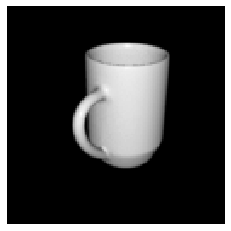

In [279]:
img = ChooseTestObject()
plt.imshow(img,cmap='gray')
plt.axis('off')
#normalize the values to between 1 and 0
img = img_as_float32(img)
#flatten image into a vector
img = img.flatten('F')

result = neuralNet.feedForward(img)
print('Predicted Class - '+objectNames[np.argmax(result)])

In [280]:
#load the saved model that we ran before
neuralNet = pickle.load( open( "model.p", "rb" ) )
neuralNet.stochasticGradientDescent(imageMatrix,expectedVals,20,2000,0.9)
pickle.dump( neuralNet, open( "model.p", "wb" ) )

testingVals = labels[0]
j=0
for obj in objectNames:
    i=0
    while i < 64:
        testingVals = np.vstack((testingVals,labels[j]))
        i+=1
    i=0
    j+=1
    
testingVals = np.delete(testingVals,1,0)

matches = 0
overall = 0
j=0
for obj in objectNames:
    i=0
    while i < 64:
        testImg = io.imread('P4Images/TestImages/'+obj+'32/UnProcessed/img_'+str(i)+'.png')
        testImg = img_as_float32(testImg)
        result = neuralNet.feedForward(testImg.flatten('F'))
        if np.argmax(result) == np.argmax(testingVals[j]):
            matches+=1
            overall+=1
        i+=1
        j+=1
    print(obj+': Got '+ str(matches) + ' correct out of 64, or ' + str(int((matches/64)*100))+'%')
    matches = 0
        
        
print('Got '+ str(overall) + ' correct out of 1280, or ' +str(int((overall/1280)*100))+'%')

'epoch #1999 done'

Cup: Got 64 correct out of 64, or 100%
Boat: Got 64 correct out of 64, or 100%
Cabinet: Got 0 correct out of 64, or 0%
Car: Got 64 correct out of 64, or 100%
Chair: Got 64 correct out of 64, or 100%
Flashlight: Got 0 correct out of 64, or 0%
Handle: Got 64 correct out of 64, or 100%
HoseReel: Got 1 correct out of 64, or 1%
Keyboard: Got 64 correct out of 64, or 100%
LED: Got 64 correct out of 64, or 100%
Light1: Got 64 correct out of 64, or 100%
Light2: Got 64 correct out of 64, or 100%
Mug: Got 0 correct out of 64, or 0%
Scooter: Got 64 correct out of 64, or 100%
SprayBottle: Got 0 correct out of 64, or 0%
Stapler: Got 64 correct out of 64, or 100%
Trash: Got 0 correct out of 64, or 0%
ibook01: Got 64 correct out of 64, or 100%
imac04: Got 0 correct out of 64, or 0%
imac98: Got 64 correct out of 64, or 100%
Got 833 correct out of 1280, or 65%
